In [182]:
# Third-party Library Imports
import numpy as np
import math as math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    r2_score,
    mean_squared_error as mse,
)
# Local Imports
from modules import forecast

# IPython Magic
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read SCM & ERA data

In [183]:
scm_era = pd.read_csv("files/ERA/processed/era_scm_final_features.csv")
scm_era = scm_era.loc[scm_era["model"].isin(["ECCC", "ECMWF", "METFR", "NASA", "NCEP", "ERA"])].reset_index(drop=True)

# store variables that are used through this notebook
init_months = scm_era["init_month"].unique().tolist()
init_months.remove(12)
unique_scm = [c for c in scm_era.model.unique().tolist() if c != "ERA"] 
weather_columns = [c for c in scm_era.columns if ("rain" in c) or ("tmean" in c)]

# preview
scm_era.sample(2)

,year,model,init_month,yield anomaly [%],tmeanrain_buenos aires coronel suarez_9,rainsquared_buenos aires hipolito yrigoyen_9,tmeanrain_buenos aires coronel suarez_11,tmeansquared_buenos aires coronel suarez_11
279,2008,METFR,11,-0.290659,0.425418,-0.641597,-2.967325,9.997873
283,2009,METFR,11,0.080890,-0.313077,1.680521,-0.418709,0.161764


In [178]:
scm_era = pd.concat([scm_era, scm_era.groupby(["year", "init_month"])[weather_columns + ["yield anomaly [%]"]].mean().reset_index().assign(model="5-member-MME")], ignore_index=True)

### 2. Train yield model and validate for each SCM

In [179]:
# Store results
results_r2 = pd.DataFrame(0.0, index=unique_scm, columns=[8, 9, 10, 11])
results_rmse = pd.DataFrame(0.0, index=unique_scm, columns=[8, 9, 10, 11])
predictions = pd.DataFrame(data={"year":list(range(1993,2017)), "yield anomaly [%]":scm_era.loc[scm_era["model"] == "ERA"].sort_values(by="year")["yield anomaly [%]"].unique()})
for month_of_initialization in init_months + [12]:
    for scm in unique_scm + ["5-member-MME"]:
        res, _ = forecast.kfold_cross_validation(scm_era, model=scm, init=month_of_initialization, augment=False, no_of_features=3)
        # store performance
        results_rmse.loc[scm, month_of_initialization] = np.round(100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False), 4)
        results_r2.loc[scm, month_of_initialization] = np.round(r2_score(res["yield anomaly [%]"], res["predicted"]), 4)
        # store predictions
        res = res.rename(columns={"predicted":"predicted_{}_{}".format(scm, month_of_initialization)})
        predictions = predictions.merge(res[["year", "predicted_{}_{}".format(scm, month_of_initialization)]], on="year")

#### 2.1 Restructure result dataframes

In [180]:
results_r2 = results_r2.transpose().stack().reset_index().rename(columns={"level_0":"init_month", "level_1":"model", 0:"R2"})
#results_r2.loc[results_r2["R2"] < 0, "R2"] = 0
results_rmse = results_rmse.transpose().stack().reset_index().rename(columns={"level_0":"init_month", "level_1":"model", 0:"RRMSE [%]"})

(results_rmse
 .loc[results_rmse["init_month"] != 12]
 .pivot_table(index="model", columns="init_month", values="RRMSE [%]", sort=False)
 .merge(results_r2
        .loc[results_r2["init_month"] != 12]
        .pivot_table(index="model", columns="init_month", values="R2", sort=False), left_index=True, right_index=True, suffixes=("_RRMSE", "_R2"))
 .transpose()
 )

model,ECCC,ECMWF,METFR,NASA,NCEP,5-member-MME
init_month,,,,,,
8_RRMSE,14.1481,13.2793,13.4772,14.8537,12.5797,13.4912
9_RRMSE,14.4792,13.5844,14.0179,12.8228,12.5907,13.2997
10_RRMSE,10.0505,9.6984,10.6244,11.1186,10.6948,10.2737
11_RRMSE,9.3337,9.6138,8.9952,9.0127,9.1948,9.0410
8_R2,-0.0957,0.0347,0.0057,-0.2078,0.1337,0.0037
9_R2,-0.1476,-0.0102,-0.0756,0.0999,0.1322,0.0318
10_R2,0.4471,0.4851,0.3821,0.3233,0.3739,0.4222
11_R2,0.5231,0.4941,0.5571,0.5553,0.5372,0.5526


#### 2.2 Create Figure 2

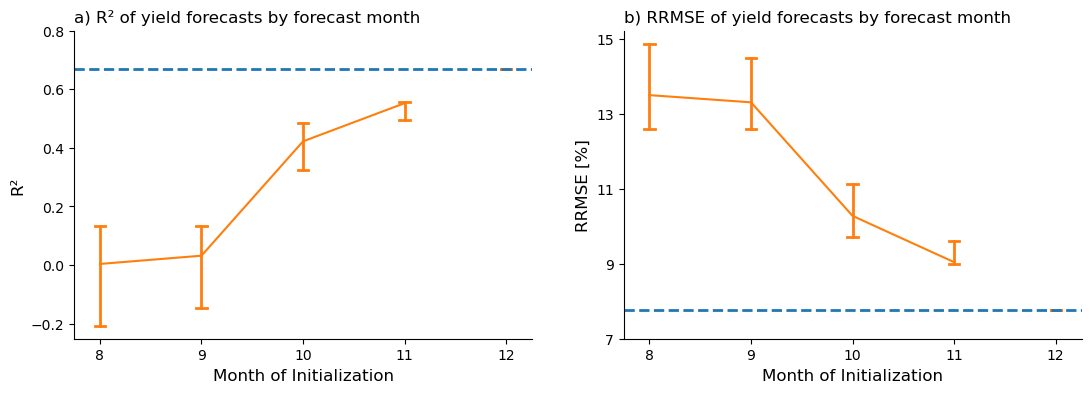

In [181]:
fig, axs = plt.subplots(1, 2, figsize=(13,4))
axs = axs.ravel()

data1 = results_r2.loc[(results_r2["model"] != "5-member-MME")]
sns.pointplot(data1,  x="init_month", y="R2", errorbar=("pi", 100),  join=False, capsize=.1, markers=".", scale=.1, color="#FF7F0E", errwidth=2, ax=axs[0])
data2 = results_r2.loc[(results_r2["init_month"] != 12) & (results_r2["model"] == "5-member-MME")]
data2.loc[:, "init_month"] = data2["init_month"].replace({8:0, 9:1, 10:2, 11:3})
sns.lineplot(data2, x="init_month", y="R2", color="#FF7F0E", ax=axs[0])
axs[0].set_title("a) R\u00b2 of yield forecasts by forecast month", loc="left", fontsize=12)
axs[0].set_xlabel("Month of Initialization", fontsize=12)
axs[0].set_yticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])
axs[0].set_ylabel("R\u00b2", fontsize=12)
axs[0].axhline(0.6691, 0, color="#1F77B4", linestyle="--", linewidth=2)
axs[0].spines[['right', 'top']].set_visible(False)

data1 = results_rmse.loc[(results_rmse["model"] != "5-member-MME")]
sns.pointplot(data1,  x="init_month", y="RRMSE [%]", errorbar=("pi", 100),  join=False, capsize=.1, markers=".", scale=.1, color="#FF7F0E", errwidth=2, ax=axs[1])
data2 = results_rmse.loc[(results_rmse["init_month"] != 12) & (results_rmse["model"] == "5-member-MME")]
data2.loc[:, "init_month"] = data2["init_month"].replace({8:0, 9:1, 10:2, 11:3})
sns.lineplot(data2, x="init_month", y="RRMSE [%]", color="#FF7F0E", ax=axs[1])
axs[1].set_title("b) RRMSE of yield forecasts by forecast month", loc="left", fontsize=12)
axs[1].set_xlabel("Month of Initialization", fontsize=12)
axs[1].set_ylabel("RRMSE [%]", fontsize=12)
axs[1].set_yticks(list(range(7, 17, 2)))
axs[1].axhline(7.7751, 0, color="#1F77B4", linestyle="--", linewidth=2)
axs[1].spines[['right', 'top']].set_visible(False)

#plt.savefig("files/figures/figure4.svg");
plt.show();


### 4. Visualize forecasts by year for Figure 5

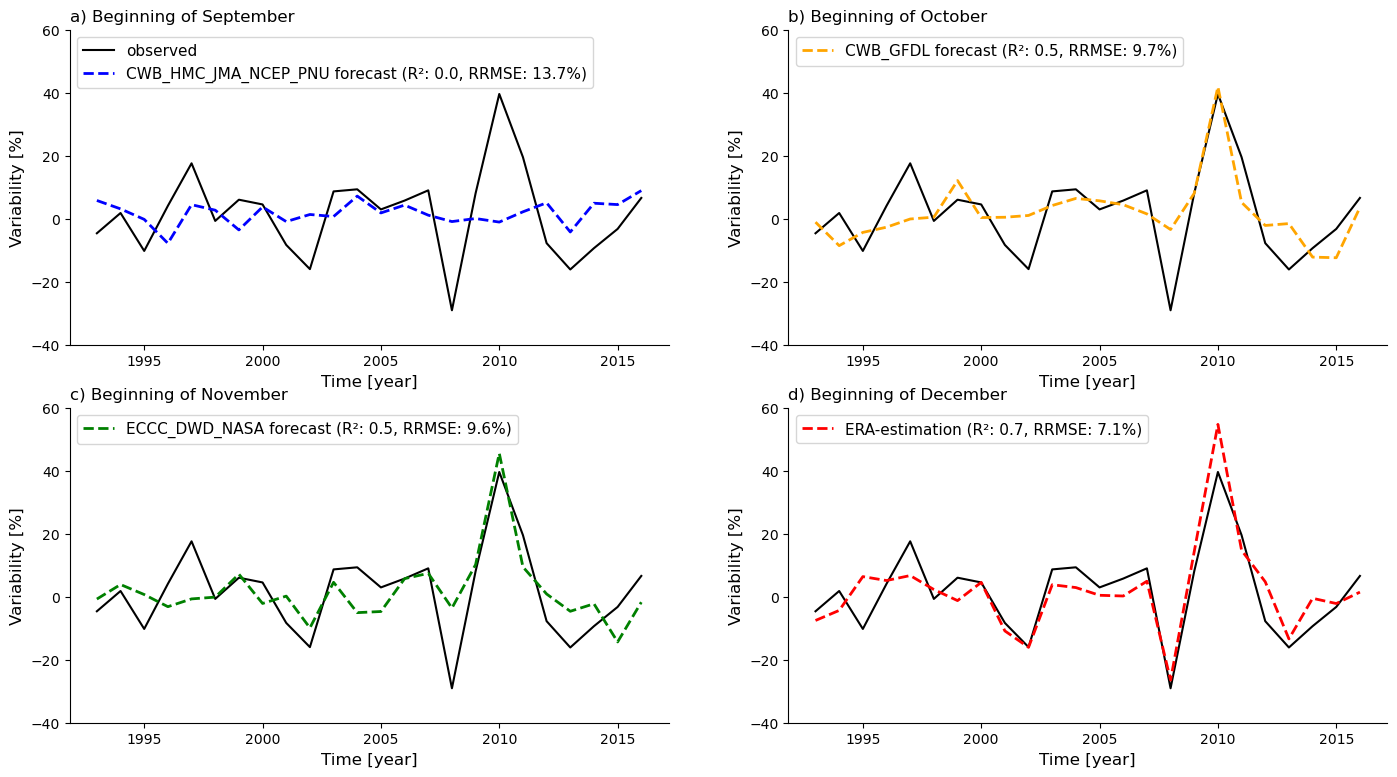

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(17, 9))
axs = axs.ravel()

axs[0].plot(predictions_best_sep_mme["year"], 100*predictions_best_sep_mme["yield anomaly [%]"], color="black", label="observed");
axs[0].plot(predictions_best_sep_mme["year"], 100*predictions_best_sep_mme["predicted"], linewidth=2, linestyle="dashed", color="blue", label="CWB_HMC_JMA_NCEP_PNU forecast (R\u00b2: {}, RRMSE: {}%)".format(round(r2_mme_9, 1), round(rmse_mme_9, 1)));
axs[0].set_title("a) Beginning of September", loc="left", fontsize=12)
axs[0].set_ylabel("Variability [%]", fontsize=12)
axs[0].set_xlabel("Time [year]", fontsize=12)
axs[0].set_yticks(list(range(-40, 70, 20)))
axs[0].spines[['right', 'top']].set_visible(False)
axs[0].legend(loc='upper left', fontsize=11)

axs[1].plot(predictions_best_oct_mme["year"], 100*predictions_best_oct_mme["yield anomaly [%]"], color="black");
axs[1].plot(predictions_best_oct_mme["year"], 100*predictions_best_oct_mme["predicted"], linewidth=2, linestyle="dashed", color="orange", label="CWB_GFDL forecast (R\u00b2: {}, RRMSE: {}%)".format(round(r2_mme_10, 1), round(rmse_mme_10, 1)));
axs[1].set_title("b) Beginning of October", loc="left", fontsize=12)
axs[1].set_ylabel("Variability [%]", fontsize=12)
axs[1].set_xlabel("Time [year]", fontsize=12)
axs[1].set_yticks(list(range(-40, 70, 20)))
axs[1].spines[['right', 'top']].set_visible(False)
axs[1].legend(loc='upper left', fontsize=11)

axs[2].plot(predictions_best_nov_mme["year"], 100*predictions_best_nov_mme["yield anomaly [%]"], color="black");
axs[2].plot(predictions_best_nov_mme["year"], 100*predictions_best_nov_mme["predicted"], linewidth=2, linestyle="dashed", color="green", label="ECCC_DWD_NASA forecast (R\u00b2: {}, RRMSE: {}%)".format(round(r2_mme_11, 1), round(rmse_mme_11, 1)));
axs[2].set_title("c) Beginning of November", loc="left", fontsize=12)
axs[2].set_ylabel("Variability [%]", fontsize=12)
axs[2].set_xlabel("Time [year]", fontsize=12)
axs[2].set_yticks(list(range(-40, 70, 20)))
axs[2].spines[['right', 'top']].set_visible(False)
axs[2].legend(loc='upper left', fontsize=11)

axs[3].plot(predictions_era["year"], 100*predictions_era["yield anomaly [%]"], color="black");
axs[3].plot(predictions_era["year"], 100*predictions_era["predicted"], linewidth=2, linestyle="dashed", color="red", label="ERA-estimation (R\u00b2: {}, RRMSE: {}%)".format(round(r2_era, 1), round(rmse_era, 1)));
axs[3].set_title("d) Beginning of December", loc="left", fontsize=12)
axs[3].set_ylabel("Variability [%]", fontsize=12)
axs[3].set_xlabel("Time [year]", fontsize=12)
axs[3].set_yticks(list(range(-40, 70, 20)))
axs[3].spines[['right', 'top']].set_visible(False)
axs[3].legend(loc='upper left', fontsize=11)

#plt.savefig("figures/figure5.png")
plt.show()
